## Отчет №2 Анализ, предобработка и разделение данных


Цели этапа:
**Текст, выделенный полужирным шрифтом**
Выполнить анализ и предобработку собранных данных, включая такие операции, как масштабирование, обрезка и нормализация изображений.
Разделить данные на три выборки: обучающую, валидационную и тестовую, для обеспечения корректного обучения и оценки модели.

**Результаты выполнения:**

Все изображения были предобработаны следующим образом:

1) Нормализация значений пикселей для согласования данных.

2) Обрезка и масштабирование изображений для приведения их к единому размеру и формату.

**Проведено разделение данных с использованием следующих пропорций:**

Обучающая выборка: 60%

Валидационная выборка: 20%

Тестовая выборка: 20%

Для корректного разделения данных было использовано случайное перемешивание, что позволило равномерно распределить изображения по классам (Грусть, Радость, Гнев) в каждой выборке. Это минимизирует вероятность смещения данных и обеспечивает надежную оценку производительности модели на независимых наборах данных.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/ИИ/дб'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import shutil
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
from PIL import Image

%matplotlib inline
warnings.filterwarnings('ignore')

In [ ]:
random_path = '/content/drive/MyDrive/ИИ/дб/Happy/05-12-21-happy-people.jpg'
Image.open(random_path)

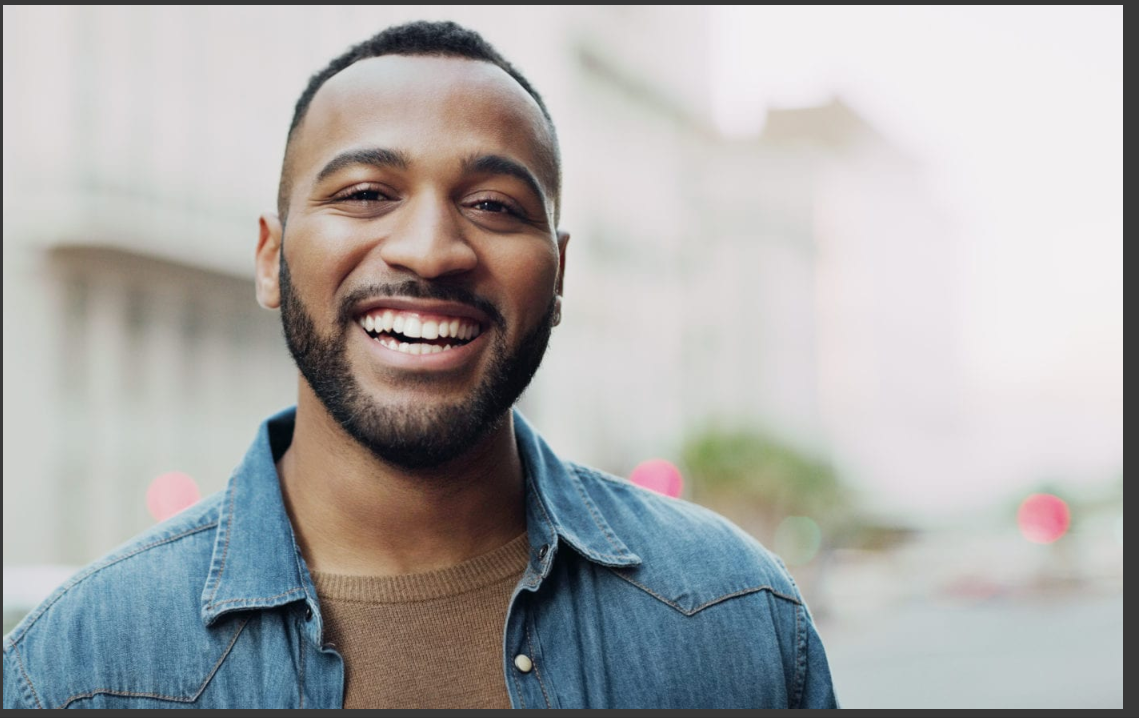

In [ ]:
PATH = '/content/drive/MyDrive/ИИ/дб'

img_dir = Path(PATH)
files = list(img_dir.glob('**/*.jpg'))

In [ ]:
# For illustration purpose
print(os.path.split(files[0]))
print(os.path.split(files[0])[0])
print(os.path.split(files[0])[0].split('/')[-1])

label = list(map(lambda x: os.path.split(x)[0].split('/')[-1], files))

In [ ]:
paths = pd.Series(files,name='Path').astype(str)
labels = pd.Series(label,name='Label')
df = pd.concat([paths,labels],axis=1)

display(df.head())
display(df.tail())
display(df.shape)

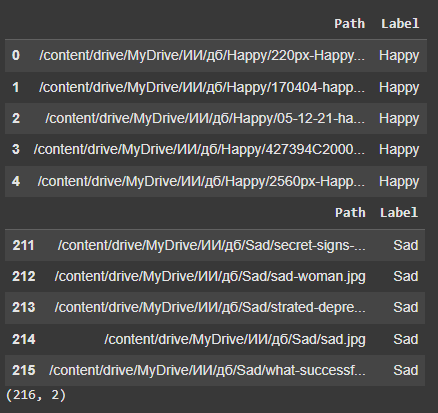

In [ ]:
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(df.Path, df.Label, test_size = 0.2, shuffle = True, random_state = 42)
display(X_tr)
display(y_tr)

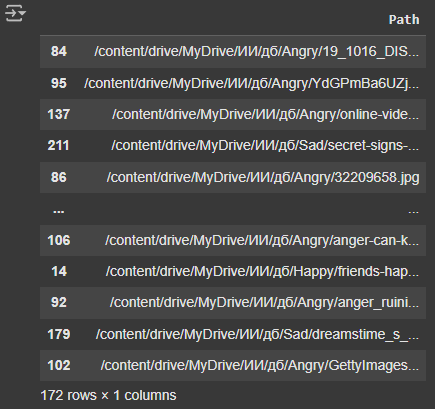

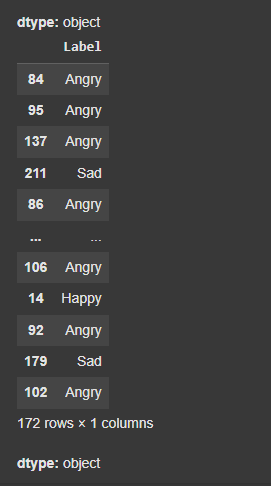

In [ ]:
df.Label.value_counts()

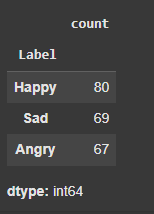

In [ ]:
plt.pie(df.Label.value_counts().values, labels=df.Label.value_counts().index, autopct='%1.1f%%')
plt.legend(loc = 'lower left')
plt.title('Percentage Breakdown of Labels')
plt.show();

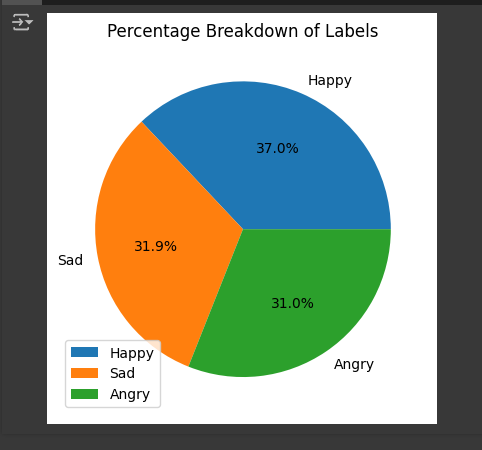

In [ ]:
# a random example
import random
random_paths = X_tr.sample(10)
random_img = [plt.imread(x) for x in random_paths]
random_img_dim = [x.shape for x in random_img]
random_img_dim

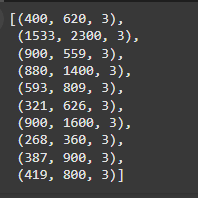

In [ ]:
class_names = np.array(sorted([item.name for item in img_dir.glob('*')]))
class_names

In [ ]:
tr, val = pd.concat([X_tr, y_tr], axis = 1).reset_index(drop = True), pd.concat([X_val, y_val], axis = 1).reset_index(drop = True)
display(tr.head())
display(val.head())

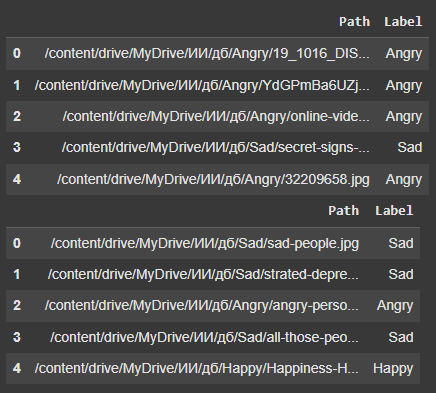

In [ ]:
label_to_int = {label: i for i, label in enumerate(tr.Label.unique())}
tr.Label = tr.Label.map(label_to_int)
val.Label = val.Label.map(label_to_int)

In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, df, transform = None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.df.loc[idx, 'Path']
        image = Image.open(img_path).convert('RGB')
        label = self.df.loc[idx, 'Label']

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label)

In [ ]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),  # scales the image's pixel intensities to the range [0, 1]
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
train = CustomImageDataset(tr, transform = transform)
valid = CustomImageDataset(val, transform = transform)

In [ ]:
BATCH_SIZE = 32
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(valid, batch_size=BATCH_SIZE)

In [ ]:
type(train_loader)

In [ ]:
train_features_batch, train_labels_batch = next(iter(train_loader))
train_features_batch.shape, train_labels_batch.shape